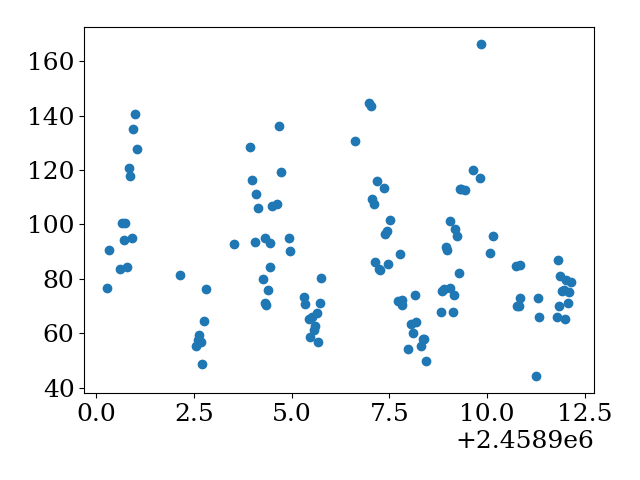

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy.time import Time
import astropy.units as u
from astropy import wcs
from astropy.utils.data import download_file
from astropy.io import fits

%matplotlib widget

plt.rcParams.update({
    "font.size": 18,
    "font.family": "serif",
    "figure.autolayout": True,
    "axes.grid": False,
    # "xtick.minor.visible": True,
    # "ytick.minor.visible": True,
})

timeOffset = 2400000.5

sector = 22
cam = 1
ccd = 3
cut = 8


interpedPos = pd.read_csv(f"./InterpolatedQuerryResult_{sector}_{cam}_{ccd}_{cut}.csv")

name = " 1999 JE82 "

interpedNamePosIDs = interpedPos.index[interpedPos["Name"] == name]
interpedNamePos = interpedPos.loc[interpedNamePosIDs]


matchedNamePos = pd.read_csv(f"./{name}Matches.csv")

plt.scatter(matchedNamePos["Time"], matchedNamePos["flux"])

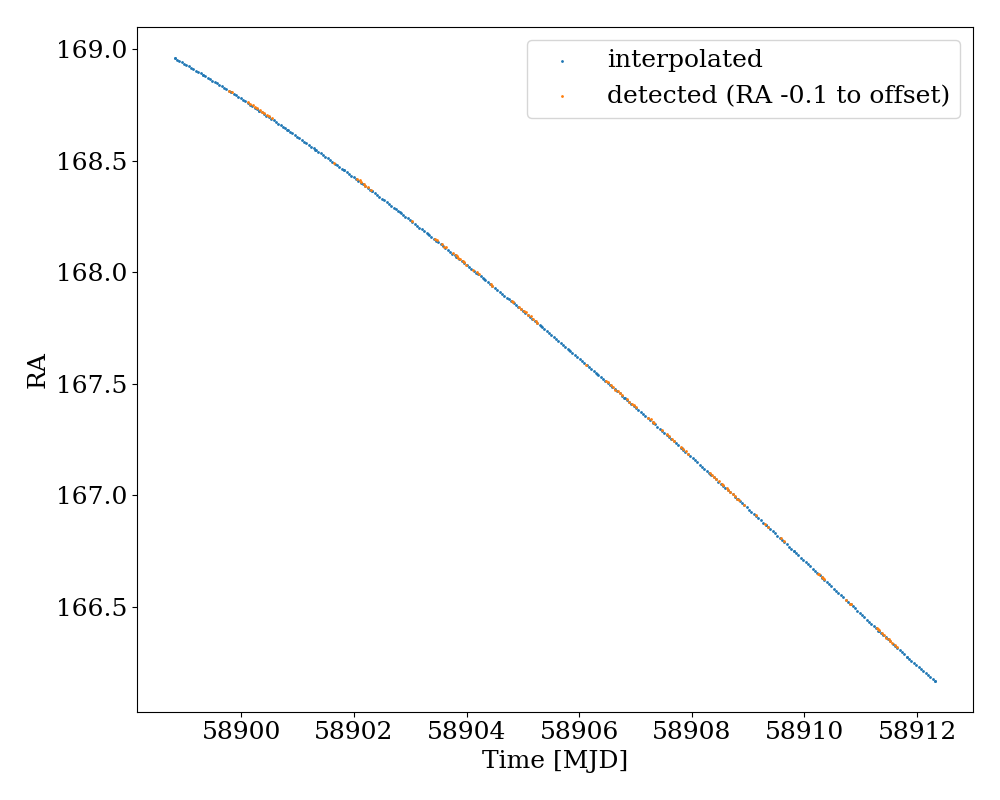

In [2]:
fig, ax = plt.subplots(1,1,figsize = (10,8))

ax.set_xlabel("Time [MJD]")
ax.set_ylabel("RA")

ax.scatter(interpedNamePos["epoch"]-timeOffset,interpedNamePos["RA"], s=1, label="interpolated")
ax.scatter(matchedNamePos["Time"]-timeOffset, matchedNamePos["RA"], s=1, label="detected (RA -0.1 to offset)") # -0.2 ofset just to see better. interp is so good that itstoo hard to see
ax.legend()

In [3]:
allFluxes = np.load(f"../OzData/sector{sector}_cam{cam}_ccd{ccd}_cut{cut}_of16_ReducedFlux.npy")

# /home/users/ble61/Documents/ASTR480/OzData/sector29_cam1_ccd3_cut7_of16_ReducedFlux.npy

numFrames = allFluxes.shape[0]
allFluxes.shape

(1246, 512, 512)

In [4]:
timesFromOz = np.load(f"../OzData/sector{sector}_cam{cam}_ccd{ccd}_cut{cut}_of16_Times.npy")

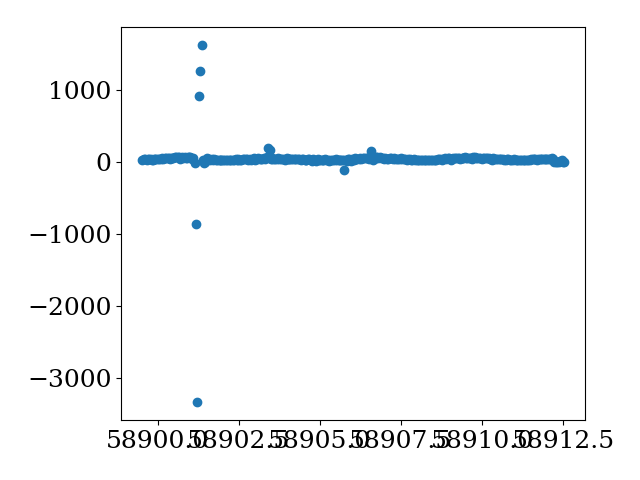

In [5]:
targetWSC = fits.open(f"../OzData/{sector}_{cam}_{ccd}_{cut}_wcs.fits")[0]

w = wcs.WCS(targetWSC.header)

interpCoords=SkyCoord(ra = interpedNamePos["RA"], dec = interpedNamePos["Dec"], unit="deg")

interpedX, interpedY  = w.all_world2pix(interpCoords.ra, interpCoords.dec,0)

interpedX = interpedX.round().astype(int)
interpedY = interpedY.round().astype(int)


startTime = targetWSC.header["MJD-OBS"]
endTime = targetWSC.header["MJD-END"]

frameTimes = np.linspace(startTime,endTime,numFrames)

#!broken way: frameNums = [ np.argmin(np.abs(frameTimes-(time-timeOffset))) for time in interpedNamePos["epoch"]] #2400000.5 is ofset between JD and MJD

frameNums = [ np.argmin(np.abs(timesFromOz -(time-timeOffset))) for time in interpedNamePos["epoch"]] #2400000.5 is 

interpedNamePos["epoch"].max() - interpedNamePos["epoch"].min()

#TODO fix the unique points to be the smallest dt
fUnq, fUnqId = np.unique(frameNums, return_index=True)

# theseFluxes = allFluxes[fUnq,xUnq.round().astype(int),yUnq.round().astype(int)]

# assert np.array_equal()
xs = interpedX[fUnqId]
ys = interpedY[fUnqId]

fluxShape = allFluxes.shape

mask = (fUnq < fluxShape[0]) & (xs < fluxShape[1]) & (ys<fluxShape[2])

xsIn = xs[mask]
ysIn = ys[mask]
fsIn = fUnq[mask]

sumFluxes = []

for f,y,x in zip(fsIn, ysIn, xsIn): #????looks like x and y is flipped
    sumFluxes.append(np.sum(allFluxes[f,y-1:y+2,x-1:x+2]))




thisLC = allFluxes[fsIn,ysIn,xsIn] #????looks like x and y is flipped

plt.figure()

plt.scatter(frameTimes[fsIn], sumFluxes)


In [6]:
w

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 167.7562656375  16.402516978253  
CRPIX : 261.65917704708  261.41148303866  
PC1_1 PC1_2  : 0.0053385908703089  0.0021781004469848  
PC2_1 PC2_2  : -0.0022632816732729  0.0052635811631893  
CDELT : 1.0  1.0  
NAXIS : 0  0

In [7]:
targetWSC2 = fits.open(f"../OzData/sector{sector}_cam{cam}_ccd{ccd}_cut{cut}_of16.fits")[2]

w2 = wcs.WCS(targetWSC2.header)
w2

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 167.7562656375  16.402516978253  
CRPIX : 261.65917704708  261.41148303866  
PC1_1 PC1_2  : 0.0053385908703089  0.0021781004469848  
PC2_1 PC2_2  : -0.0022632816732729  0.0052635811631893  
CDELT : 1.0  1.0  
NAXIS : 512  512

In [8]:
plt.scatter(timesFromOz,(timesFromOz-frameTimes))

np.mean(np.abs(timesFromOz-frameTimes))

0.274983066301969

In [9]:
(endTime-startTime)/frameTimes.shape[0] *24



0.5232696383885058

hrs/frame

-46.54797074272606

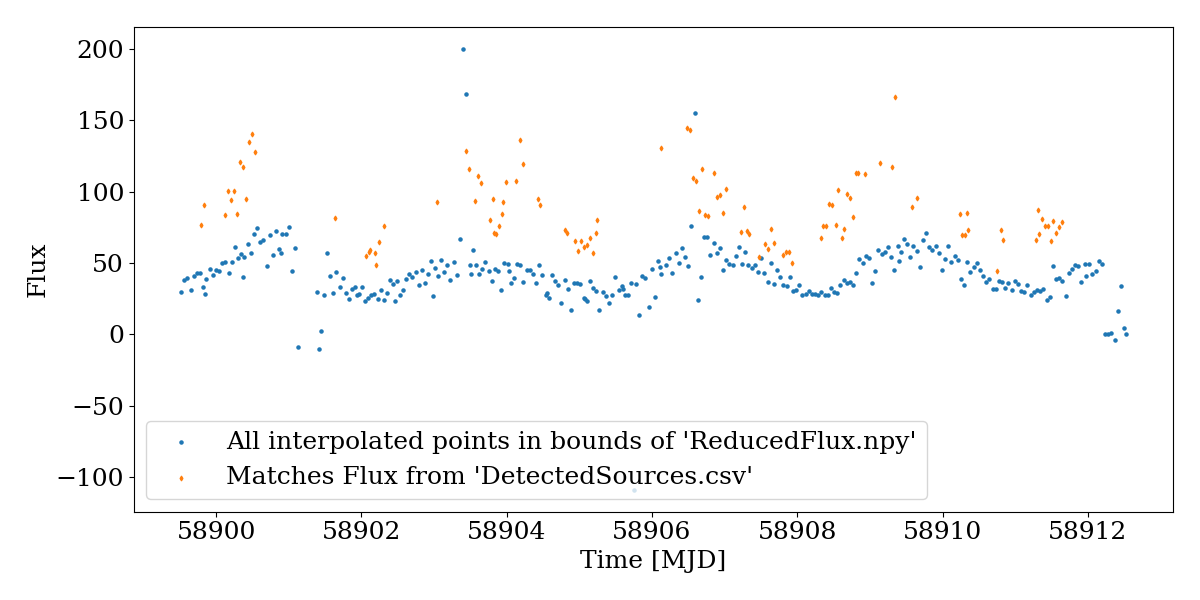

In [14]:
pSize = 5
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.set_xlabel("Time [MJD]")
ax.set_ylabel("Flux")
                                        #* CUT off huge ones 
ax.scatter(frameTimes[fsIn], np.where(np.abs(sumFluxes)<300, sumFluxes, np.nan), s=pSize, label = "All interpolated points in bounds of 'ReducedFlux.npy'")

matchedMeanFlux = np.mean(matchedNamePos["flux"])

# ax.scatter(matchedNamePos["Time"]-timeOffset, matchedNamePos["flux"]-matchedMeanFlux, s=pSize, label = f"Matches Flux from Detected Sources (around 0 by subtracting mean = {matchedMeanFlux.round(2)})")

ax.scatter(matchedNamePos["Time"]-timeOffset, matchedNamePos["flux"], s=pSize, marker="d",label = f"Matches Flux from 'DetectedSources.csv'")

ax.legend()

# fig.savefig(f"./Testing Figures/differentFluxes{name}.pdf")

# np.argmax(sumFluxes)

np.nanmean(sumFluxes)- matchedMeanFlux

/usr/local/anaconda3/lib/python3.10/site-packages/scipy/ndimage/_measurements.py:1541: RuntimeWarning: invalid value encountered in scalar divide
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


ValueError: cannot convert float NaN to integer

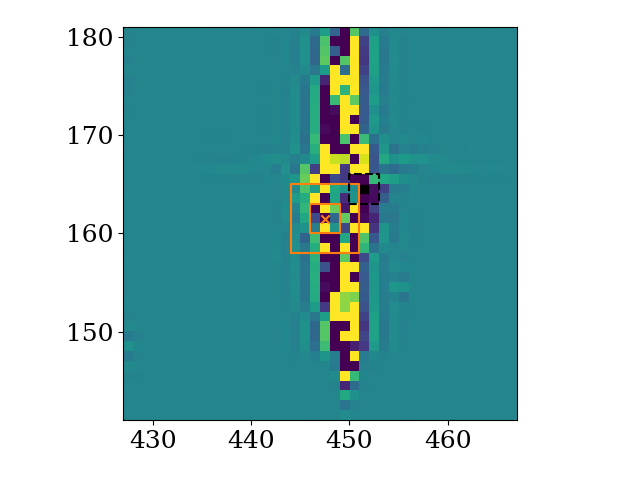

In [38]:
point = np.argmax(sumFluxes)
numPx = 20

#????looks like x and y is flipped

x = xsIn[point]
y = ysIn[point]

fig, ax = plt.subplots()

toShow = allFluxes[fsIn[point],y-numPx:y+numPx,x-numPx:x+numPx]

ax.imshow(toShow, extent = [x-numPx,x+numPx,y-numPx,y+numPx], vmin=np.percentile(toShow, 3), vmax=np.percentile(toShow,97))
ax.scatter(x+0.5,y+0.5, c="tab:orange", marker="x")

#4x4 box,
checkUp = 4
checkDown = 3

#3x3 box
sumUp = 2
sumDown = 1


ax.plot([x-checkDown,x+checkUp,x+checkUp,x-checkDown,x-checkDown],[y-checkDown,y-checkDown,y+checkUp,y+checkUp,y-checkDown], c="tab:orange")
ax.plot([x-sumDown,x+sumUp,x+sumUp,x-sumDown,x-sumDown],[y-sumDown,y-sumDown,y+sumUp,y+sumUp,y-sumDown], c="tab:orange")


coordSum = np.sum(allFluxes[fsIn[point],y-sumDown:y+sumUp,x-sumDown:x+sumUp])

from scipy import ndimage

com = np.round(ndimage.center_of_mass(allFluxes[fsIn[point],y-checkDown:y+checkUp,x-checkDown:x+checkUp]))

adjCom = (int(round(com[0]+y-3)), int(round(com[1]+x-3)))

ax.scatter(adjCom[1]+0.5, adjCom[0]+0.5, marker="s", c="k")

ax.plot([adjCom[1]-sumDown,adjCom[1]+sumUp,adjCom[1]+sumUp,adjCom[1]-sumDown,adjCom[1]-sumDown],[adjCom[0]-sumDown,adjCom[0]-sumDown,adjCom[0]+sumUp,adjCom[0]+sumUp,adjCom[0]-sumDown], c="k", ls="--")

comSum = np.sum(allFluxes[fsIn[point],adjCom[0]-sumDown:adjCom[0]+sumUp,adjCom[1]-sumDown:adjCom[1]+sumUp])

sumFluxesCom = []

for f,y,x in zip(fsIn, ysIn, xsIn): #????looks like x and y is flipped
    com = np.round(ndimage.center_of_mass(allFluxes[f,y-checkDown:y+checkUp,x-checkDown:x+checkUp]))

    adjCom = (int(round(com[0]+y-3)), int(round(com[1]+x-3)))
    
    x2 = adjCom[1]
    y2 = adjCom[0]

    sumFluxesCom.append(np.sum(allFluxes[f,y2-sumDown:y2+sumUp,x2-sumDown:x2+sumUp]))


-8.971112688333069

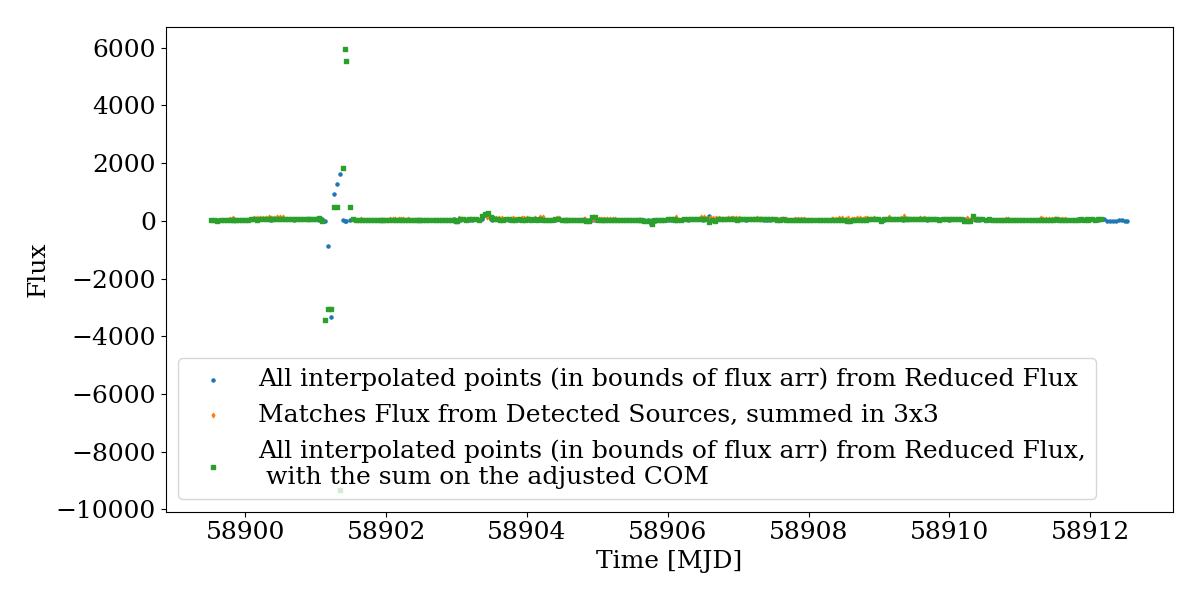

In [19]:
pSize = 5
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.set_xlabel("Time [MJD]")
ax.set_ylabel("Flux")

ax.scatter(frameTimes[fsIn], sumFluxes, s=pSize, label = "All interpolated points (in bounds of flux arr) from Reduced Flux ")

ax.scatter(matchedNamePos["Time"]-timeOffset, matchedNamePos["flux"], s=pSize,marker="d", label = f"Matches Flux from Detected Sources, summed in 3x3")

ax.scatter(frameTimes[fsIn[:len(sumFluxesCom)]], sumFluxesCom, s=pSize, marker ="s", label = "All interpolated points (in bounds of flux arr) from Reduced Flux,\n with the sum on the adjusted COM ")

matchedMeanFlux = np.mean(matchedNamePos["flux"])

# ax.scatter(matchedNamePos["Time"]-timeOffset, matchedNamePos["flux"]-matchedMeanFlux, s=pSize, label = f"Matches Flux from Detected Sources (around 0 by subtracting mean = {matchedMeanFlux.round(2)})")



ax.legend()



np.mean(sumFluxesCom)-np.mean(sumFluxes)


0.40690532074682384

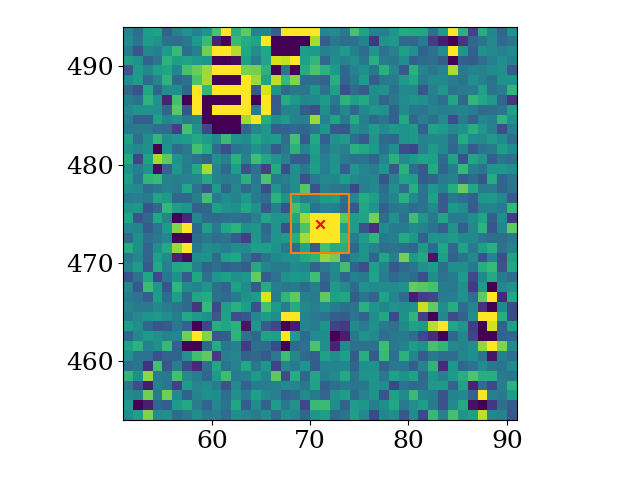

In [ ]:

detectedPix = SkyCoord(matchedNamePos["RA"], matchedNamePos["Dec"], unit="deg" )

detcX, detcY = w.all_world2pix(detectedPix.ra, detectedPix.dec,0)


detcX = detcX.round().astype(int)
detcY = detcY.round().astype(int)

#! detcFrameNums = [ np.argmin(np.abs(frameTimes-(time))) for time in matchedNamePos["mjd"]]

detcFrameNums = [ np.argmin(np.abs(timesFromOz-(time))) for time in matchedNamePos["mjd"]]



point = 123
numPx = 20

#????looks like x and y is flipped

x = detcX[point]
y = detcY[point]

fig, ax = plt.subplots()

toShow = allFluxes[detcFrameNums[point],y-numPx:y+numPx,x-numPx:x+numPx]

ax.imshow(toShow, extent = [x-numPx,x+numPx,y-numPx,y+numPx], vmin=np.percentile(toShow, 3), vmax=np.percentile(toShow,97))
ax.scatter(x,y, c="r", marker="x")

ax.plot([x-3,x+3,x+3,x-3,x-3],[y-3,y-3,y+3,y+3,y-3], c="tab:orange")


np.sum(allFluxes[fsIn[point],x-3:x+3,y-3:y+3])
